<a href="https://colab.research.google.com/github/Kazuhiko-Miyata/CIFAR10_CNN_model_predict/blob/main/CIFAR10_CNN_model_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **DataLoaderの設定**
データ拡張として、回転とリサイズ、および左右反転を行う。また、学習が効率的になるように入力の平均値を0、標準偏差を1にする（標準化）。

DataLoaderでは、訓練データ、テストデータでそれぞれ設定する。

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

cifar10_classes =["airplane", "automobile", "bird",
                  "cat", "deer", "dog", "frog", "horse",
                  "ship", "truck"]

affine = transforms.RandomAffine((-30, 30),
                                 scale=(0.8, 1.2))
flip = transforms.RandomHorizontalFlip(p=0.5)
normalize = transforms.Normalize((0.0, 0.0, 0.0),
                                 (1.0, 1.0, 1.0))
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine,
                                      flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])

cifar10_train = CIFAR10("./data", train=True,
                      download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False,
                       download=True, transform=transform_test)

batch_size = 64
train_loader = DataLoader(cifar10_train,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test,
                         batch_size=batch_size, shuffle=False)

Writing dataloader_set.py


## **CNNモデルの構築**
nn.Module()クラスを継承したクラスとして、CNNのモデルを構築する。畳み込み層の後には活性化関数としてReLUを配置し、その次にプーリング層を置く。プーリング層とReLU層は、学習するパラメータがないので一度設定すれば使い回しができる。また、汎化性能向上のためにドロップアウトを導入する。

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #畳み込み層:（入力チャンネル数、フィルタ数、フィルタサイズ）
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        #プーリング層:（領域サイズ、領域の間隔）
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)#全結合層
        self.dropout = nn.Dropout(p=0.5)
        #ドロップアウト:（p=ドロップアウト率）
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.view(-1, 16*5*5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


上記のモデルの各層で、画像のサイズ（チャンネル数、画像の高さ、画像の幅）は以下のように変化する。




```
入力画像:(3, 32, 32)
↓
nn.Conv2d(3, 6, 5):(6, 28, 28)
↓
nn.MaxPool2d(2, 2):(6, 14, 14)
↓
nn.Conv2d(6, 16, 5):(16, 10, 10)
↓
nn.MaxPool2d(2, 2):(16, 5, 5)
```

以下の個所の16×5×5は上記の結果得られた入力の数



```
self.fc1 = nn.Linear(16*5*5, 256)#全結合層
```



## **学習**
CNNモデルの訓練を行う。
DataLoaderを使い、ミニバッチを取り出して訓練及び評価を行う。

In [2]:
rom torch import optim

#交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

#最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

#損失のログ
record_loss_train = []
record_loss_test = []

#学習
for i in range(20):#20エポック学習
    net.train()#訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):
      #ミニバッチ(x, t)を取り出す
      x, t = x.cuda(), t.cuda()#GPU対応
      y = net(x)
      loss = loss_fnc(y, t)
      loss_train += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()#評価モード
    loss_test = 0

    for j, (x, t) in enumerate(test_loader):
      #ミニバッチ(x, t)を取り出す
      x, t = x.cuda(), t.cuda()
      y = net(x)
      loss = loss_fnc(y, t)
      loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 ==0:
        print("Epoch:", i, "Loss_Train:",
              loss_train, "Loss_Test:", loss_test)

cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
for batch_idx, (images, labels) in enumerate(cifar10_loader):
    print(f"Batch{batch_idx + 1}:")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

plt.imshow(images[0].permute(1, 2, 0))
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()

net.eval()
x, t = images.cuda(), labels.cuda(),
y = net(x)
print("正解:", cifar10_classes[labels[0]],
      "予測結果:", cifar10_classes[y.argmax().item()])

Writing CIFAR10_model_predict.py


## **誤差の推移**
訓練データとテストデータそれぞれの誤差の推移をグラフで表示する

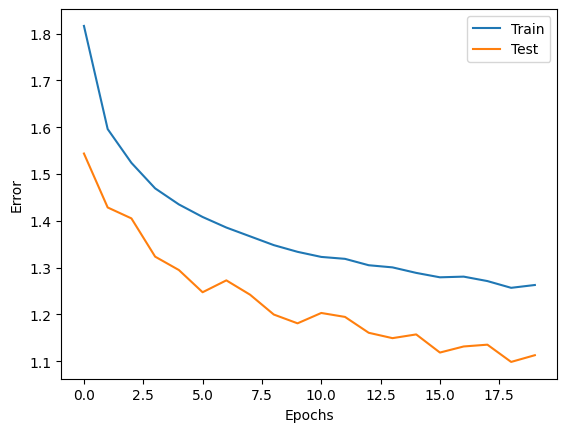

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)),
         record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)),
         record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## **正解率**
モデルの性能を把握するため、テストデータを使い正解率を測定する。

In [ ]:
correct = 0
total = 0
net.eval()#評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 60.91%


## **訓練済みのモデルを使った予測**
画像を入力し、モデルが機能しているか確認する。

ストリーミング出力は最後の 5000 行に切り捨てられました。
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size([1])
Batch8335:
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size([1])
Batch8336:
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size([1])
Batch8337:
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size([1])
Batch8338:
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size([1])
Batch8339:
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size([1])
Batch8340:
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size([1])
Batch8341:
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size([1])
Batch8342:
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size([1])
Batch8343:
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size([1])
Batch8344:
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size([1])
Batch8345:
Images shape: torch.Size([1, 3, 32, 32])
Labels shape: torch.Size(

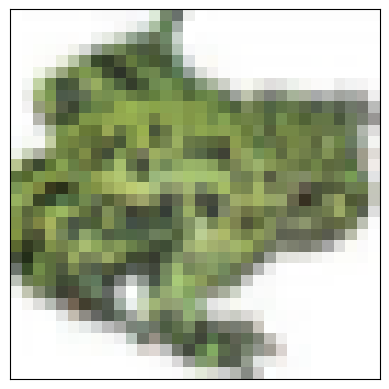

正解: frog 予測結果: frog


In [ ]:
cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
for batch_idx, (images, labels) in enumerate(cifar10_loader):
    print(f"Batch{batch_idx + 1}:")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

plt.imshow(images[0].permute(1, 2, 0))
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()

net.eval()
x, t = images.cuda(), labels.cuda(),
y = net(x)
print("正解:", cifar10_classes[labels[0]],
      "予測結果:", cifar10_classes[y.argmax().item()])

## **演習**

## **DataLoaderの設定**

In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

affine = transforms.RandomAffine((-30, 30),
                                 scale=(0.8, 1.2))
flip = transforms.RandomHorizontalFlip(p=0.5)
normalize = transforms.Normalize((0.0, 0.0, 0.0),(1.0, 1.0, 1.0))
to_tensor = transforms.ToTensor()
erase = transforms.RandomErasing(p=0.5)

transform_train = transforms.Compose([affine, flip, normalize,
                                      to_tensor, erase])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

     def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16*5*5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()
print(net)

from torch import optim

loss_fnc = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters())

record_loss_train = []
record_loss_test = []

for i in range(20):
   net.train()
   loss_train = 0
   for j, (x, t) in enumerate(train_loader)

Files already downloaded and verified
Files already downloaded and verified
